In [1]:
import numpy as np
import awkward as ak
np.random.seed(1337)  # for reproducibility

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import utils as pic

%load_ext autoreload
%autoreload 2

In [2]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 64       # Training batch size
train_size  = 1024     # Training size
valid_size  = 1024     # Validation size
test_size   = 1024     # Test size
epochs      = 20       # Number of epochs
doGPU       = False    # Use GPU

In [3]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(pic.decays)*train_size) % batch_size == 0
X_train, y_train = pic.load_data(train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = pic.load_data(valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = pic.load_data(test_start,test_stop)

samples_requested = len(pic.decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

In [4]:
X_e_train, X_t_train, maxframes, time_bins = pic.timeordered_BC(X_train, cumulative=False )

scaler = MinMaxScaler().fit(X_e_train.reshape(-1,maxframes*32*32))
scale_input = lambda X : scaler.transform(X.reshape(-1,maxframes*32*32)).reshape(X.shape)

X_e_train = scale_input(X_e_train)

[-0.05   -0.0401 -0.0302 -0.0203 -0.0104 -0.0005  0.0094  0.0193  0.0292
  0.0391  0.049 ]


In [5]:
X_e_valid, X_t_valid, maxframes, time_bins = pic.timeordered_BC(X_valid, cumulative=False )
X_e_valid = scale_input(X_e_valid)

[-0.05   -0.0401 -0.0302 -0.0203 -0.0104 -0.0005  0.0094  0.0193  0.0292
  0.0391  0.049 ]


In [6]:
X_e_test, X_t_test, _, _ = pic.timeordered_BC(X_test, cumulative=False)
X_e_test = scale_input(X_e_test)

[-0.05   -0.0401 -0.0302 -0.0203 -0.0104 -0.0005  0.0094  0.0193  0.0292
  0.0391  0.049 ]


In [7]:
model = keras.Sequential()

model.add(layers.Reshape((maxframes, 32, 32, 1),input_shape=(maxframes, 32, 32)))
model.add(layers.ConvLSTM2D(32, 3, activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(16,3,activation='relu',padding='same'))
model.add(layers.MaxPool2D())
model.add(layers.Flatten())
model.add(layers.Dense(25,activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 11, 32, 32, 1)     0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 32, 32, 32)        38144     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [9]:
history = model.fit(
    X_e_train, y_train,
    validation_data=(X_e_valid,y_valid),
    epochs=5,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)

Epoch 1/5
32/32 [==============================] - 47s 1s/step - loss: 0.6868 - accuracy: 0.5361 - val_loss: 0.6960 - val_accuracy: 0.5156
Epoch 2/5
32/32 [==============================] - 48s 2s/step - loss: 0.6785 - accuracy: 0.5854 - val_loss: 0.6940 - val_accuracy: 0.5083
Epoch 3/5
32/32 [==============================] - 45s 1s/step - loss: 0.6677 - accuracy: 0.6001 - val_loss: 0.6952 - val_accuracy: 0.5229
Epoch 4/5
32/32 [==============================] - 46s 1s/step - loss: 0.6599 - accuracy: 0.5952 - val_loss: 0.7045 - val_accuracy: 0.5610
Epoch 5/5
32/32 [==============================] - 45s 1s/step - loss: 0.6454 - accuracy: 0.6143 - val_loss: 0.7942 - val_accuracy: 0.5234


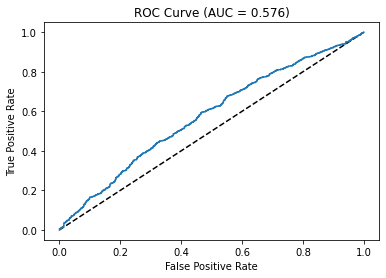

In [16]:
pic.plot_roc(y_test, model.predict(X_e_test))